# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import string
import subprocess
import re
from collections import Counter
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kag

# **Load Dataset**

In [2]:
df=pd.read_csv(r'/kaggle/input/fake-news-classification/WELFake_Dataset.csv',index_col=0)
print(df.shape)
df.head()

(72134, 3)


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# **EDA**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [4]:
df.dropna(inplace=True)

<Axes: ylabel='count'>

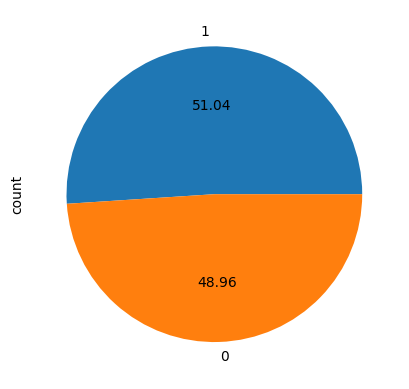

In [5]:
df.label.value_counts().plot.pie(autopct='%.2f')

In [6]:
df['full_text'] = df['title'] + ' ' + df['text']

In [7]:
def normalize_text(text):
    # 1. Convert text to lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # 4. Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Tokenize the text
    tokens = word_tokenize(text)

    # 6. Remove stopwords and numeric tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [
        token for token in tokens
        if token not in stop_words and token.isalpha()
    ]

    # 7. Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # 8. Join tokens back into a single string
    return ' '.join(lemmatized_tokens)

In [8]:
df['full_text']=df['full_text'].apply(normalize_text)

# **Visualizations**

In [9]:
fake_text = df[df.label == 0]['full_text']
real_text = df[df.label == 1]['full_text']

In [10]:
fake_text.head()

3     bobby jindal raised hindu us story christian c...
11    may brexit offer would hurt cost eu citizen eu...
12    schumer call trump appoint official oversee pu...
14    change expected espn political agenda despite ...
15    billionaire odebrecht brazil scandal released ...
Name: full_text, dtype: object

In [11]:
real_text.head()

0    law enforcement high alert following threat co...
2    unbelievable obamas attorney general say charl...
4    satan russia unvelis image terrifying new supe...
5    time christian group sue amazon splc designati...
6    dr ben carson targeted irs never audit spoke n...
Name: full_text, dtype: object

In [12]:
def plot_top_words(common_words, title):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

In [13]:
fake_words_counter = Counter(' '.join(fake_text).split())
real_words_counter = Counter(' '.join(real_text).split())
top_fake_words = fake_words_counter.most_common(10)
top_real_words = real_words_counter.most_common(10)
print(top_fake_words)
print(top_real_words)

[('said', 184625), ('trump', 115031), ('mr', 71031), ('state', 70136), ('would', 62656), ('u', 62106), ('president', 51473), ('new', 50062), ('year', 46630), ('one', 43630)]
[('trump', 111219), ('u', 51345), ('people', 49018), ('clinton', 48198), ('said', 47061), ('one', 45964), ('would', 43036), ('state', 42822), ('president', 38225), ('hillary', 34432)]


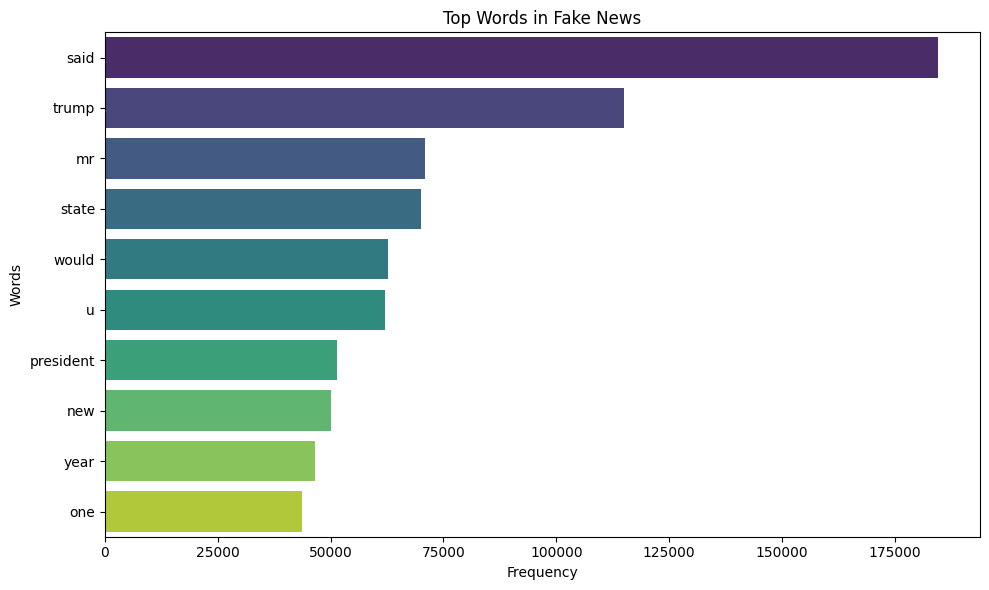

In [14]:
plot_top_words(top_fake_words, "Top Words in Fake News")

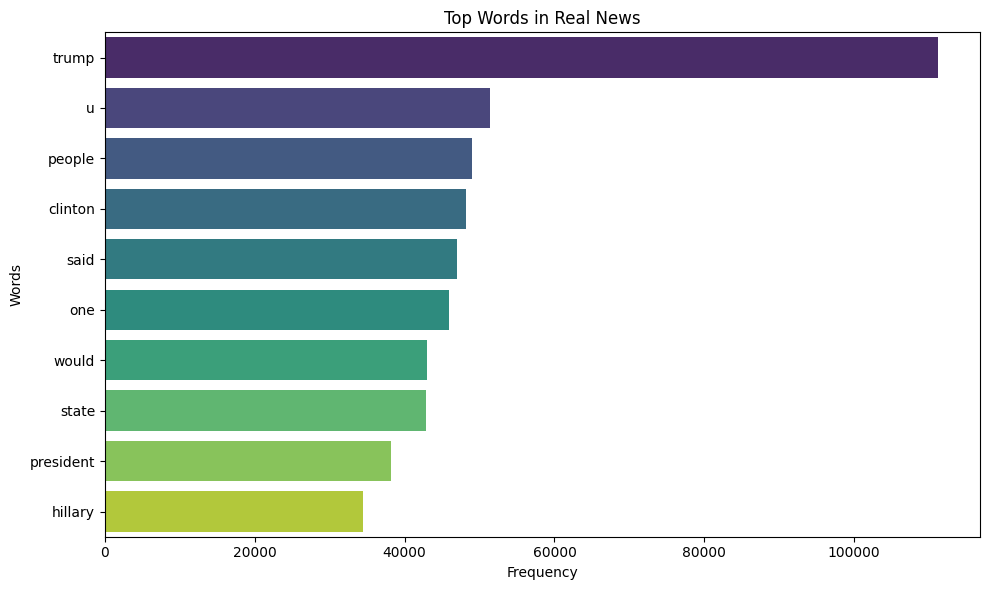

In [15]:
plot_top_words(top_real_words, "Top Words in Real News")

In [16]:
def generate_wordcloud_from_frequencies(word_frequencies, title):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_frequencies)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

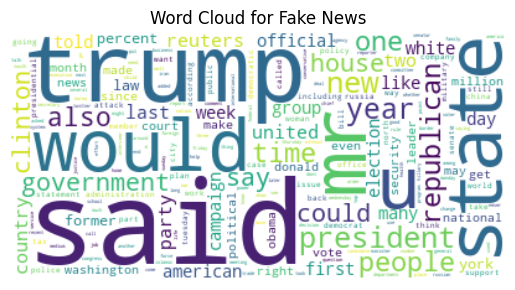

In [17]:
generate_wordcloud_from_frequencies(fake_words_counter, "Word Cloud for Fake News")

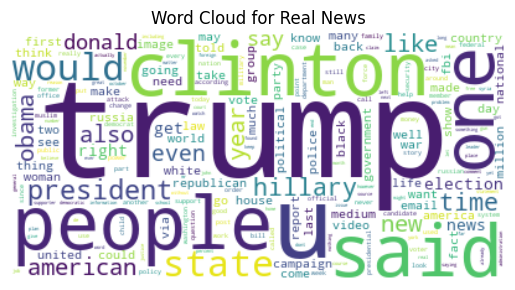

In [18]:
generate_wordcloud_from_frequencies(real_words_counter, "Word Cloud for Real News")

# **Model Training and Evaluation**

In [19]:
X=df['full_text']
y=df['label']

In [20]:
# Create the TF-IDF matrix
vectorizer = TfidfVectorizer(min_df=100,
                             max_df=0.90,
                             stop_words='english',
                             max_features=10000)

X = vectorizer.fit_transform(X)

feature_names = vectorizer.get_feature_names_out()

X = X.toarray()

print("Feature Names (Words):")
print(feature_names)

print("\nTF-IDF Matrix (dense format):")
print(X)

Feature Names (Words):
['aaron' 'abadi' 'abandon' ... 'zone' 'zoo' 'zuckerberg']

TF-IDF Matrix (dense format):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [23]:
y_pred=rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9538020687727146


In [24]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      7006
           1       0.94      0.97      0.96      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



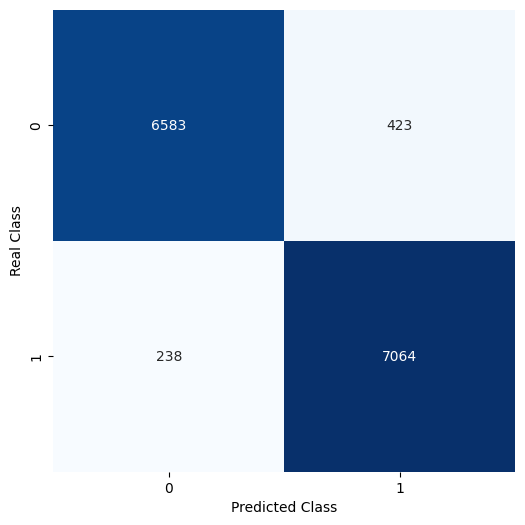

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()